# Convolution Neural Network (Convnet)

## CNN on CPU

In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
REBUILD_DATA = True  

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "data/PetImages/Cat"
    DOGS = "data/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append(
                        [np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    print(str(e))
                    pass
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print("Cats:",self.catcount)
        print("Dogs:",self.dogcount)
        
if REBUILD_DATA:
    dogvcats = DogsVSCats()
    dogvcats.make_training_data()

  1%|          | 81/12501 [00:00<00:15, 802.21it/s]

data/PetImages/Cat


  2%|▏         | 240/12501 [00:00<00:15, 798.07it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



  5%|▍         | 584/12501 [00:00<00:14, 844.19it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



  8%|▊         | 1035/12501 [00:01<00:13, 864.01it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 12%|█▏        | 1472/12501 [00:01<00:14, 784.34it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 15%|█▌        | 1912/12501 [00:02<00:12, 869.82it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 17%|█▋        | 2175/12501 [00:02<00:11, 865.07it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 25%|██▍       | 3063/12501 [00:03<00:11, 827.06it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 36%|███▌      | 4475/12501 [00:05<00:09, 820.58it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 41%|████▏     | 5163/12501 [00:06<00:08, 826.63it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 43%|████▎     | 5422/12501 [00:06<00:08, 829.47it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 55%|█████▍    | 6856/12501 [00:08<00:08, 690.27it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 62%|██████▏   | 7726/12501 [00:09<00:05, 852.91it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 71%|███████   | 8851/12501 [00:10<00:04, 842.97it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 83%|████████▎ | 10372/12501 [00:12<00:02, 875.19it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 87%|████████▋ | 10897/12501 [00:13<00:01, 828.55it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 93%|█████████▎| 11641/12501 [00:14<00:01, 695.88it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 95%|█████████▌| 11915/12501 [00:14<00:00, 652.21it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 97%|█████████▋| 12180/12501 [00:14<00:00, 762.34it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 99%|█████████▊| 12340/12501 [00:14<00:00, 774.76it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



  1%|          | 73/12501 [00:00<00:17, 725.56it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

data/PetImages/Dog


  2%|▏         | 311/12501 [00:00<00:15, 771.94it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



  4%|▍         | 553/12501 [00:00<00:15, 793.71it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



  8%|▊         | 960/12501 [00:01<00:14, 791.99it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 13%|█▎        | 1663/12501 [00:02<00:14, 754.88it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 16%|█▌        | 1982/12501 [00:02<00:13, 773.06it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 17%|█▋        | 2142/12501 [00:02<00:13, 775.52it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 24%|██▎       | 2954/12501 [00:03<00:12, 785.16it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 29%|██▉       | 3613/12501 [00:04<00:11, 803.26it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 33%|███▎      | 4180/12501 [00:05<00:10, 783.49it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 36%|███▌      | 4496/12501 [00:05<00:10, 753.22it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 38%|███▊      | 4738/12501 [00:06<00:10, 776.15it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 40%|███▉      | 4973/12501 [00:06<00:09, 768.32it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 41%|████      | 5129/12501 [00:06<00:09, 759.84it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 44%|████▎     | 5460/12501 [00:07<00:08, 809.31it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 51%|█████     | 6360/12501 [00:08<00:08, 713.63it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 62%|██████▏   | 7778/12501 [00:10<00:05, 799.63it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 66%|██████▌   | 8275/12501 [00:10<00:05, 802.85it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 68%|██████▊   | 8443/12501 [00:11<00:04, 814.29it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 72%|███████▏  | 8992/12501 [00:11<00:04, 745.17it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 75%|███████▌  | 9398/12501 [00:12<00:04, 749.32it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 78%|███████▊  | 9722/12501 [00:12<00:03, 772.04it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 83%|████████▎ | 10363/12501 [00:13<00:02, 767.70it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 90%|████████▉ | 11191/12501 [00:14<00:01, 797.84it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



 94%|█████████▍| 11721/12501 [00:15<00:01, 653.80it/s]

OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 12501/12501 [00:16<00:00, 764.27it/s]


OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Cats: 12476
Dogs: 12470


In [3]:
np.eye(3)[1]

array([0., 1., 0.])

In [4]:
np.eye(3)[2]

array([0., 0., 1.])

In [5]:
REBUILD_DATA = False

In [6]:
training_data = np.load("training_data.npy", allow_pickle=True)

print(len(training_data))

24946


In [7]:
print(training_data[1])

[array([[ 90, 138,  74, ...,  67,  88,  86],
       [109,  56,  51, ...,  59,  75,  59],
       [ 97,  55,  53, ...,  79, 106,  84],
       ...,
       [ 34,  49,  41, ...,  36,  15,  37],
       [ 42,  49,  44, ...,  30,  17,  26],
       [ 46,  52,  39, ...,  25,  20,  30]], dtype=uint8)
 array([0., 1.])]


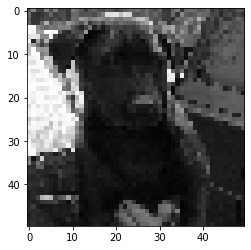

In [8]:
plt.imshow(training_data[1][0],cmap="gray")
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        print(x[0].shape)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    
net=Net()

torch.Size([128, 2, 2])


In [11]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

val_pct = 0.1
val_size = int(len(X)*val_pct)
print(val_size)

2494


In [12]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [13]:
BATCH_SIZE = 100
EPOCHS = 1

In [14]:
BATCH_SIZE = 100
EPOCHS = 3
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        # print(i,i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()  # OR model.zero_grad()   OR optimizer.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f"EPOCH: {epoch}.  Loss: {loss}")

print(loss)

  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:04,  3.48it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<01:03,  3.50it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:01,  3.62it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:00,  3.64it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:01<01:00,  3.64it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:01<00:59,  3.68it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<00:58,  3.74it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:02<00:56,  3.82it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:02<00:57,  3.77it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:02<00:56,  3.76it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:03<00:55,  3.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:03<00:56,  3.73it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:03<00:57,  3.65it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:04<00:59,  3.54it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:04<01:00,  3.48it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:04<01:01,  3.39it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:05<00:59,  3.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:05<01:03,  3.24it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:06<01:01,  3.32it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:06<00:58,  3.44it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:06<00:59,  3.38it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:07<00:59,  3.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:07<01:00,  3.31it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:07<01:02,  3.18it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:08<01:03,  3.12it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:08<01:02,  3.14it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:08<01:05,  3.00it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:09<01:04,  2.99it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:09<01:05,  2.97it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:09<01:05,  2.95it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:10<01:04,  2.97it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:10<01:06,  2.87it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:10<01:07,  2.79it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:11<01:08,  2.75it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:11<01:08,  2.74it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:12<01:09,  2.69it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:12<01:09,  2.66it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:12<01:06,  2.77it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:13<01:06,  2.75it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:13<01:08,  2.67it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:13<01:10,  2.56it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:14<01:08,  2.64it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:14<01:05,  2.74it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:14<01:02,  2.83it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:15<01:02,  2.83it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:15<00:59,  2.95it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:15<01:01,  2.86it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:16<00:59,  2.90it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:16<01:00,  2.85it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:17<01:01,  2.81it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:17<01:01,  2.78it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:17<01:00,  2.80it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:18<01:00,  2.81it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:18<01:00,  2.77it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:18<00:58,  2.84it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:19<00:56,  2.95it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:19<00:55,  2.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:20<00:58,  2.78it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:20<00:57,  2.80it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:20<00:55,  2.90it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:21<00:53,  2.99it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:21<00:52,  3.03it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:22<00:51,  3.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:22<00:51,  3.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:23<00:52,  2.92it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:23<00:54,  2.81it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:23<00:54,  2.80it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:24<00:54,  2.75it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:24<00:54,  2.74it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:25<00:52,  2.83it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:25<00:48,  3.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:25<00:46,  3.13it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:26<00:43,  3.30it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:26<00:40,  3.53it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:26<00:38,  3.65it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:27<00:39,  3.60it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:27<00:39,  3.52it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:27<00:39,  3.49it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:28<00:40,  3.41it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:28<00:41,  3.31it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:28<00:41,  3.29it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:29<00:41,  3.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:29<00:42,  3.12it/s]

torch.Size([128, 2, 2])


 41%|████▏     | 93/225 [00:30<00:42,  3.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:30<00:43,  3.02it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:30<00:46,  2.78it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:31<00:42,  3.01it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:31<00:41,  3.08it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:32<00:39,  3.16it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:32<00:40,  3.08it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:32<00:41,  3.02it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:33<00:41,  2.95it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:33<00:41,  2.93it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:33<00:41,  2.91it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:34<00:39,  3.01it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:34<00:41,  2.89it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:34<00:40,  2.91it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:35<00:39,  2.94it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:35<00:38,  2.98it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:35<00:37,  3.06it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:36<00:36,  3.08it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:36<00:36,  3.05it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:36<00:38,  2.90it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:37<00:39,  2.83it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:37<00:38,  2.83it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:37<00:38,  2.84it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:38<00:38,  2.83it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:38<00:38,  2.81it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:38<00:36,  2.92it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:39<00:36,  2.90it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:39<00:35,  2.96it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:39<00:33,  3.07it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:40<00:32,  3.13it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:40<00:32,  3.07it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:41<00:31,  3.17it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:41<00:30,  3.26it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:41<00:29,  3.31it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:42<00:28,  3.32it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:42<00:27,  3.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:42<00:29,  3.23it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:43<00:29,  3.19it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:43<00:29,  3.12it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:43<00:28,  3.16it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:43<00:28,  3.20it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:44<00:27,  3.18it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:44<00:27,  3.24it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:44<00:26,  3.30it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:45<00:26,  3.30it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:45<00:25,  3.29it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:45<00:25,  3.29it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:46<00:25,  3.25it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:46<00:25,  3.19it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:46<00:25,  3.18it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:47<00:24,  3.23it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:47<00:24,  3.19it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:47<00:25,  3.06it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:48<00:25,  3.07it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:48<00:24,  3.10it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:48<00:24,  3.12it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:49<00:23,  3.14it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:49<00:23,  3.17it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:49<00:23,  3.12it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:49<00:22,  3.18it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:50<00:21,  3.18it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:50<00:21,  3.21it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:50<00:20,  3.24it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:51<00:20,  3.31it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:51<00:19,  3.34it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:51<00:19,  3.26it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:52<00:20,  3.15it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:52<00:20,  3.07it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:52<00:20,  3.02it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:53<00:18,  3.24it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:53<00:17,  3.31it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:53<00:17,  3.39it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:54<00:16,  3.43it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:54<00:16,  3.48it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:54<00:16,  3.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:55<00:16,  3.28it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:55<00:15,  3.33it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:55<00:14,  3.63it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:56<00:12,  3.89it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:56<00:12,  3.82it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:56<00:12,  3.84it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:57<00:12,  3.72it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:57<00:12,  3.61it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:57<00:12,  3.52it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:57<00:12,  3.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:58<00:13,  3.23it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:58<00:13,  3.01it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:59<00:13,  2.96it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:59<00:13,  3.02it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:59<00:13,  2.95it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [01:00<00:13,  2.89it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [01:00<00:13,  2.82it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [01:00<00:12,  2.83it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [01:01<00:12,  2.82it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [01:01<00:11,  2.84it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [01:01<00:11,  2.79it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [01:02<00:11,  2.90it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [01:02<00:09,  3.01it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:03<00:09,  3.14it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:03<00:08,  3.24it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:03<00:08,  3.28it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:03<00:07,  3.31it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:04<00:07,  3.39it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 201/225 [01:04<00:06,  3.58it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:04<00:06,  3.62it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:05<00:06,  3.42it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:05<00:06,  3.42it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:05<00:05,  3.42it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:06<00:05,  3.51it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:06<00:04,  3.68it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:06<00:04,  3.83it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:06<00:03,  3.78it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:07<00:03,  3.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:07<00:03,  3.41it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:08<00:03,  3.35it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:08<00:02,  3.41it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:08<00:02,  3.49it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:09<00:02,  3.54it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:09<00:01,  3.61it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:09<00:01,  3.52it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:10<00:01,  3.57it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:10<00:00,  3.59it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:10<00:00,  3.60it/s]

torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:11<00:00,  3.58it/s]

torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
EPOCH: 0.  Loss: 0.2510908246040344
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:02,  3.58it/s]

torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<01:00,  3.69it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<00:59,  3.71it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<00:58,  3.74it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:01<00:59,  3.66it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:01<00:59,  3.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:04,  3.38it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:02<01:07,  3.18it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:02<01:10,  3.05it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:03<01:08,  3.12it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:03<01:03,  3.35it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:04<01:00,  3.50it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:04<00:58,  3.58it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:04<00:56,  3.70it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:04<00:54,  3.78it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:05<00:54,  3.81it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:05<00:53,  3.85it/s]

torch.Size([128, 2, 2])


  9%|▉         | 20/225 [00:05<00:51,  3.98it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:05<00:52,  3.86it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:06<00:52,  3.89it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:06<00:52,  3.86it/s]

torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:06<00:52,  3.81it/s]

torch.Size([128, 2, 2])


 11%|█         | 25/225 [00:06<00:51,  3.91it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:07<00:51,  3.88it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:07<00:50,  3.93it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 28/225 [00:07<00:50,  3.91it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:07<00:48,  4.01it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:08<00:47,  4.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:08<00:50,  3.86it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:08<00:54,  3.53it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:09<00:55,  3.46it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:09<00:52,  3.59it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:09<00:50,  3.71it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:10<00:49,  3.81it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:10<00:48,  3.82it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:10<00:47,  3.92it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:10<00:46,  3.95it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:11<00:46,  3.97it/s]

torch.Size([128, 2, 2])


 19%|█▊        | 42/225 [00:11<00:46,  3.94it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:11<00:45,  3.99it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:11<00:46,  3.93it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:12<00:45,  3.99it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:12<00:45,  3.96it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:12<00:45,  3.88it/s]

torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:12<00:45,  3.93it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:13<00:45,  3.87it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 50/225 [00:13<00:44,  3.95it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:13<00:44,  3.91it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 52/225 [00:13<00:44,  3.88it/s]

torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:14<00:44,  3.83it/s]

torch.Size([128, 2, 2])


 24%|██▍       | 54/225 [00:14<00:44,  3.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:14<00:45,  3.70it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:15<00:47,  3.58it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 58/225 [00:15<00:49,  3.39it/s]

torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:15<00:47,  3.52it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:16<00:47,  3.46it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:16<00:46,  3.52it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:16<00:46,  3.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:17<00:46,  3.47it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:17<00:48,  3.35it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:17<00:50,  3.18it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:18<00:49,  3.18it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:18<00:49,  3.21it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:18<00:48,  3.22it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:19<00:49,  3.14it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:19<00:49,  3.12it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:19<00:49,  3.13it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:19<00:48,  3.16it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:20<00:48,  3.14it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 74/225 [00:20<00:48,  3.13it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:20<00:48,  3.08it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:21<00:49,  2.99it/s]

torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:21<00:46,  3.15it/s]

torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:22<00:44,  3.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:22<00:42,  3.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:23<00:41,  3.41it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:23<00:42,  3.34it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:23<00:40,  3.47it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:24<00:38,  3.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:24<00:38,  3.57it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:24<00:39,  3.44it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:25<00:39,  3.40it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:25<00:40,  3.35it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:25<00:38,  3.47it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:26<00:37,  3.48it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:26<00:37,  3.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:27<00:38,  3.36it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:27<00:40,  3.19it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:27<00:41,  3.03it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 99/225 [00:28<00:42,  2.96it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:28<00:40,  3.11it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:28<00:38,  3.22it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:29<00:37,  3.26it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:29<00:36,  3.32it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:29<00:37,  3.24it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:30<00:36,  3.25it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:30<00:36,  3.28it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:30<00:35,  3.28it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:31<00:35,  3.28it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:31<00:35,  3.21it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:31<00:35,  3.18it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:32<00:35,  3.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:32<00:36,  3.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:33<00:37,  2.92it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:33<00:36,  2.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:34<00:36,  2.95it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:34<00:37,  2.80it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:34<00:35,  2.97it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:35<00:31,  3.27it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:35<00:30,  3.34it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:36<00:30,  3.30it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:36<00:30,  3.27it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:36<00:30,  3.27it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:37<00:29,  3.28it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:37<00:30,  3.22it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:37<00:29,  3.24it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:37<00:29,  3.23it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:38<00:29,  3.22it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:38<00:28,  3.24it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:38<00:28,  3.27it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:39<00:28,  3.24it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:39<00:28,  3.19it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:39<00:28,  3.13it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:40<00:27,  3.15it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:40<00:27,  3.18it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:40<00:26,  3.26it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 140/225 [00:41<00:25,  3.32it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:41<00:24,  3.36it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:41<00:24,  3.41it/s]

torch.Size([128, 2, 2])


 64%|██████▎   | 143/225 [00:41<00:25,  3.28it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:42<00:24,  3.32it/s]

torch.Size([128, 2, 2])


 64%|██████▍   | 145/225 [00:42<00:23,  3.35it/s]

torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:42<00:22,  3.44it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:43<00:22,  3.41it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:43<00:22,  3.42it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:43<00:22,  3.35it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:44<00:22,  3.32it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:44<00:22,  3.33it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:44<00:22,  3.25it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:44<00:21,  3.29it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:45<00:21,  3.36it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:45<00:21,  3.30it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:45<00:21,  3.27it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:46<00:21,  3.21it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:46<00:21,  3.17it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:47<00:19,  3.37it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:47<00:18,  3.44it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:47<00:18,  3.49it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 163/225 [00:47<00:18,  3.44it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:48<00:18,  3.30it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:48<00:18,  3.32it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:49<00:16,  3.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:49<00:17,  3.31it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:49<00:17,  3.26it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:50<00:17,  3.16it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:50<00:16,  3.20it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:50<00:16,  3.13it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:51<00:15,  3.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:51<00:14,  3.40it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:51<00:14,  3.36it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:52<00:14,  3.38it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:52<00:14,  3.17it/s]

torch.Size([128, 2, 2])


 80%|███████▉  | 179/225 [00:52<00:14,  3.13it/s]

torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:53<00:14,  3.02it/s]

torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:53<00:14,  2.94it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:53<00:14,  3.01it/s]

torch.Size([128, 2, 2])


 81%|████████▏ | 183/225 [00:54<00:14,  2.94it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:54<00:14,  2.92it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:55<00:13,  2.96it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:55<00:12,  3.09it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:55<00:12,  3.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:56<00:11,  3.17it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 190/225 [00:56<00:11,  3.12it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:56<00:11,  3.08it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:57<00:10,  3.18it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [00:57<00:09,  3.17it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 195/225 [00:58<00:09,  3.09it/s]

torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [00:58<00:09,  2.97it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [00:58<00:09,  3.07it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:59<00:08,  3.11it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [00:59<00:07,  3.26it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [00:59<00:07,  3.34it/s]

torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:00<00:07,  3.15it/s]

torch.Size([128, 2, 2])


 90%|█████████ | 203/225 [01:00<00:06,  3.22it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:00<00:06,  3.26it/s]

torch.Size([128, 2, 2])


 91%|█████████ | 205/225 [01:01<00:06,  3.19it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:01<00:05,  3.20it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:01<00:05,  3.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:02<00:05,  3.28it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:02<00:05,  3.16it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:02<00:04,  3.01it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:03<00:04,  2.85it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:03<00:04,  2.70it/s]

torch.Size([128, 2, 2])


 95%|█████████▍| 213/225 [01:04<00:04,  2.67it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:04<00:04,  2.61it/s]

torch.Size([128, 2, 2])


 96%|█████████▌| 215/225 [01:04<00:03,  2.62it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:05<00:02,  2.85it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:05<00:02,  2.93it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:06<00:02,  2.89it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:06<00:01,  2.94it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:06<00:01,  3.00it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:07<00:01,  2.96it/s]

torch.Size([128, 2, 2])


 99%|█████████▉| 223/225 [01:07<00:00,  3.02it/s]

torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
EPOCH: 1.  Loss: 0.2195717692375183
torch.Size([128, 2, 2])


  1%|          | 2/225 [00:00<01:05,  3.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  1%|▏         | 3/225 [00:00<01:07,  3.28it/s]

torch.Size([128, 2, 2])


  2%|▏         | 4/225 [00:01<01:08,  3.23it/s]

torch.Size([128, 2, 2])


  2%|▏         | 5/225 [00:01<01:08,  3.20it/s]

torch.Size([128, 2, 2])


  3%|▎         | 6/225 [00:01<01:07,  3.23it/s]

torch.Size([128, 2, 2])


  3%|▎         | 7/225 [00:02<01:10,  3.11it/s]

torch.Size([128, 2, 2])


  4%|▎         | 8/225 [00:02<01:08,  3.17it/s]

torch.Size([128, 2, 2])


  4%|▍         | 9/225 [00:02<01:08,  3.14it/s]

torch.Size([128, 2, 2])


  4%|▍         | 10/225 [00:03<01:08,  3.12it/s]

torch.Size([128, 2, 2])


  5%|▍         | 11/225 [00:03<01:11,  3.01it/s]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:03<01:10,  3.02it/s]

torch.Size([128, 2, 2])


  6%|▌         | 13/225 [00:04<01:11,  2.95it/s]

torch.Size([128, 2, 2])


  6%|▌         | 14/225 [00:04<01:10,  3.01it/s]

torch.Size([128, 2, 2])


  7%|▋         | 15/225 [00:04<01:10,  2.99it/s]

torch.Size([128, 2, 2])


  7%|▋         | 16/225 [00:05<01:08,  3.07it/s]

torch.Size([128, 2, 2])


  8%|▊         | 17/225 [00:05<01:07,  3.08it/s]

torch.Size([128, 2, 2])


  8%|▊         | 18/225 [00:05<01:07,  3.08it/s]

torch.Size([128, 2, 2])


  8%|▊         | 19/225 [00:06<01:06,  3.12it/s]

torch.Size([128, 2, 2])


  9%|▉         | 21/225 [00:06<01:01,  3.34it/s]

torch.Size([128, 2, 2])


 10%|▉         | 22/225 [00:06<00:59,  3.39it/s]

torch.Size([128, 2, 2])


 10%|█         | 23/225 [00:07<00:57,  3.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:07<00:58,  3.45it/s]

torch.Size([128, 2, 2])


 12%|█▏        | 26/225 [00:08<01:01,  3.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 12%|█▏        | 27/225 [00:08<01:07,  2.92it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 29/225 [00:09<01:05,  3.01it/s]

torch.Size([128, 2, 2])


 13%|█▎        | 30/225 [00:09<01:00,  3.24it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 31/225 [00:09<00:56,  3.43it/s]

torch.Size([128, 2, 2])


 14%|█▍        | 32/225 [00:10<00:53,  3.58it/s]

torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:10<00:51,  3.70it/s]

torch.Size([128, 2, 2])


 15%|█▌        | 34/225 [00:10<00:50,  3.75it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 35/225 [00:10<00:50,  3.76it/s]

torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:11<00:50,  3.72it/s]

torch.Size([128, 2, 2])


 16%|█▋        | 37/225 [00:11<00:50,  3.72it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 38/225 [00:11<00:50,  3.73it/s]

torch.Size([128, 2, 2])


 17%|█▋        | 39/225 [00:11<00:51,  3.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 18%|█▊        | 40/225 [00:12<00:50,  3.63it/s]

torch.Size([128, 2, 2])


 18%|█▊        | 41/225 [00:12<00:52,  3.52it/s]

torch.Size([128, 2, 2])


 19%|█▉        | 43/225 [00:13<00:52,  3.44it/s]

torch.Size([128, 2, 2])


 20%|█▉        | 44/225 [00:13<00:50,  3.56it/s]

torch.Size([128, 2, 2])


 20%|██        | 45/225 [00:13<00:49,  3.63it/s]

torch.Size([128, 2, 2])


 20%|██        | 46/225 [00:13<00:48,  3.68it/s]

torch.Size([128, 2, 2])


 21%|██        | 47/225 [00:14<00:47,  3.74it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:14<00:49,  3.57it/s]

torch.Size([128, 2, 2])


 22%|██▏       | 49/225 [00:14<00:51,  3.39it/s]

torch.Size([128, 2, 2])


 23%|██▎       | 51/225 [00:15<00:56,  3.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▎       | 53/225 [00:16<00:55,  3.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:16<00:53,  3.17it/s]

torch.Size([128, 2, 2])


 25%|██▍       | 56/225 [00:17<00:52,  3.24it/s]

torch.Size([128, 2, 2])


 25%|██▌       | 57/225 [00:17<00:50,  3.32it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:17<00:49,  3.38it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 27%|██▋       | 60/225 [00:18<00:49,  3.31it/s]

torch.Size([128, 2, 2])


 27%|██▋       | 61/225 [00:18<00:53,  3.06it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 62/225 [00:18<00:55,  2.96it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 63/225 [00:19<00:55,  2.90it/s]

torch.Size([128, 2, 2])


 28%|██▊       | 64/225 [00:19<00:54,  2.97it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 65/225 [00:19<00:53,  3.00it/s]

torch.Size([128, 2, 2])


 29%|██▉       | 66/225 [00:20<00:51,  3.08it/s]

torch.Size([128, 2, 2])


 30%|██▉       | 67/225 [00:20<00:51,  3.04it/s]

torch.Size([128, 2, 2])


 30%|███       | 68/225 [00:20<00:54,  2.89it/s]

torch.Size([128, 2, 2])


 31%|███       | 69/225 [00:21<00:54,  2.85it/s]

torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:21<00:56,  2.75it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 71/225 [00:22<00:55,  2.76it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 72/225 [00:22<00:53,  2.85it/s]

torch.Size([128, 2, 2])


 32%|███▏      | 73/225 [00:22<00:51,  2.96it/s]

torch.Size([128, 2, 2])


 33%|███▎      | 75/225 [00:23<00:45,  3.28it/s]

torch.Size([128, 2, 2])


 34%|███▍      | 76/225 [00:23<00:43,  3.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▍      | 78/225 [00:24<00:43,  3.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 35%|███▌      | 79/225 [00:24<00:44,  3.26it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 80/225 [00:24<00:45,  3.22it/s]

torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:25<00:45,  3.18it/s]

torch.Size([128, 2, 2])


 36%|███▋      | 82/225 [00:25<00:44,  3.18it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 83/225 [00:25<00:43,  3.29it/s]

torch.Size([128, 2, 2])


 37%|███▋      | 84/225 [00:26<00:43,  3.26it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 85/225 [00:26<00:43,  3.23it/s]

torch.Size([128, 2, 2])


 38%|███▊      | 86/225 [00:26<00:43,  3.21it/s]

torch.Size([128, 2, 2])


 39%|███▊      | 87/225 [00:26<00:41,  3.30it/s]

torch.Size([128, 2, 2])


 39%|███▉      | 88/225 [00:27<00:40,  3.36it/s]

torch.Size([128, 2, 2])


 40%|███▉      | 89/225 [00:27<00:41,  3.30it/s]

torch.Size([128, 2, 2])


 40%|████      | 90/225 [00:27<00:39,  3.39it/s]

torch.Size([128, 2, 2])


 40%|████      | 91/225 [00:28<00:40,  3.32it/s]

torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:28<00:39,  3.37it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 94/225 [00:29<00:38,  3.44it/s]

torch.Size([128, 2, 2])


 42%|████▏     | 95/225 [00:29<00:36,  3.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 43%|████▎     | 96/225 [00:29<00:36,  3.50it/s]

torch.Size([128, 2, 2])


 43%|████▎     | 97/225 [00:29<00:36,  3.50it/s]

torch.Size([128, 2, 2])


 44%|████▎     | 98/225 [00:30<00:38,  3.30it/s]

torch.Size([128, 2, 2])


 44%|████▍     | 100/225 [00:30<00:36,  3.44it/s]

torch.Size([128, 2, 2])


 45%|████▍     | 101/225 [00:31<00:35,  3.45it/s]

torch.Size([128, 2, 2])


 45%|████▌     | 102/225 [00:31<00:34,  3.58it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 103/225 [00:31<00:34,  3.49it/s]

torch.Size([128, 2, 2])


 46%|████▌     | 104/225 [00:31<00:34,  3.49it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:32<00:33,  3.55it/s]

torch.Size([128, 2, 2])


 47%|████▋     | 106/225 [00:32<00:32,  3.62it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 107/225 [00:32<00:32,  3.62it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 108/225 [00:32<00:31,  3.67it/s]

torch.Size([128, 2, 2])


 48%|████▊     | 109/225 [00:33<00:30,  3.81it/s]

torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:33<00:29,  3.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 111/225 [00:33<00:32,  3.54it/s]

torch.Size([128, 2, 2])


 50%|████▉     | 112/225 [00:34<00:33,  3.35it/s]

torch.Size([128, 2, 2])


 50%|█████     | 113/225 [00:34<00:34,  3.25it/s]

torch.Size([128, 2, 2])


 51%|█████     | 114/225 [00:34<00:33,  3.27it/s]

torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:35<00:33,  3.28it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 116/225 [00:35<00:32,  3.31it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 117/225 [00:35<00:32,  3.28it/s]

torch.Size([128, 2, 2])


 52%|█████▏    | 118/225 [00:35<00:32,  3.30it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 119/225 [00:36<00:32,  3.22it/s]

torch.Size([128, 2, 2])


 53%|█████▎    | 120/225 [00:36<00:32,  3.24it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:36<00:31,  3.25it/s]

torch.Size([128, 2, 2])


 54%|█████▍    | 122/225 [00:37<00:31,  3.23it/s]

torch.Size([128, 2, 2])


 55%|█████▍    | 123/225 [00:37<00:31,  3.21it/s]

torch.Size([128, 2, 2])


 55%|█████▌    | 124/225 [00:37<00:31,  3.20it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 125/225 [00:38<00:31,  3.17it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 126/225 [00:38<00:31,  3.16it/s]

torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:38<00:30,  3.17it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 128/225 [00:39<00:31,  3.09it/s]

torch.Size([128, 2, 2])


 57%|█████▋    | 129/225 [00:39<00:31,  3.04it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 130/225 [00:39<00:31,  3.02it/s]

torch.Size([128, 2, 2])


 58%|█████▊    | 131/225 [00:40<00:31,  2.99it/s]

torch.Size([128, 2, 2])


 59%|█████▊    | 132/225 [00:40<00:33,  2.78it/s]

torch.Size([128, 2, 2])


 59%|█████▉    | 133/225 [00:40<00:32,  2.80it/s]

torch.Size([128, 2, 2])


 60%|█████▉    | 134/225 [00:41<00:32,  2.77it/s]

torch.Size([128, 2, 2])


 60%|██████    | 135/225 [00:41<00:32,  2.78it/s]

torch.Size([128, 2, 2])


 60%|██████    | 136/225 [00:42<00:31,  2.84it/s]

torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:42<00:31,  2.82it/s]

torch.Size([128, 2, 2])


 61%|██████▏   | 138/225 [00:42<00:31,  2.72it/s]

torch.Size([128, 2, 2])


 62%|██████▏   | 139/225 [00:43<00:31,  2.74it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 141/225 [00:43<00:29,  2.86it/s]

torch.Size([128, 2, 2])


 63%|██████▎   | 142/225 [00:44<00:28,  2.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:44<00:25,  3.12it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 146/225 [00:45<00:23,  3.31it/s]

torch.Size([128, 2, 2])


 65%|██████▌   | 147/225 [00:45<00:23,  3.31it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:45<00:23,  3.22it/s]

torch.Size([128, 2, 2])


 66%|██████▌   | 149/225 [00:46<00:23,  3.25it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 150/225 [00:46<00:23,  3.16it/s]

torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:46<00:24,  2.97it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 152/225 [00:47<00:24,  2.98it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 153/225 [00:47<00:23,  3.00it/s]

torch.Size([128, 2, 2])


 68%|██████▊   | 154/225 [00:47<00:23,  3.03it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 155/225 [00:48<00:22,  3.08it/s]

torch.Size([128, 2, 2])


 69%|██████▉   | 156/225 [00:48<00:22,  3.03it/s]

torch.Size([128, 2, 2])


 70%|██████▉   | 157/225 [00:48<00:22,  3.08it/s]

torch.Size([128, 2, 2])


 70%|███████   | 158/225 [00:49<00:21,  3.05it/s]

torch.Size([128, 2, 2])


 71%|███████   | 159/225 [00:49<00:21,  3.05it/s]

torch.Size([128, 2, 2])


 71%|███████   | 160/225 [00:49<00:20,  3.12it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 161/225 [00:50<00:20,  3.13it/s]

torch.Size([128, 2, 2])


 72%|███████▏  | 162/225 [00:50<00:20,  3.12it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 164/225 [00:51<00:18,  3.24it/s]

torch.Size([128, 2, 2])


 73%|███████▎  | 165/225 [00:51<00:18,  3.32it/s]

torch.Size([128, 2, 2])


 74%|███████▍  | 166/225 [00:51<00:17,  3.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 74%|███████▍  | 167/225 [00:52<00:17,  3.25it/s]

torch.Size([128, 2, 2])


 75%|███████▍  | 168/225 [00:52<00:18,  3.11it/s]

torch.Size([128, 2, 2])


 75%|███████▌  | 169/225 [00:52<00:17,  3.12it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:53<00:17,  3.14it/s]

torch.Size([128, 2, 2])


 76%|███████▌  | 171/225 [00:53<00:17,  3.15it/s]

torch.Size([128, 2, 2])


 76%|███████▋  | 172/225 [00:53<00:16,  3.15it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 173/225 [00:53<00:16,  3.15it/s]

torch.Size([128, 2, 2])


 77%|███████▋  | 174/225 [00:54<00:16,  3.14it/s]

torch.Size([128, 2, 2])


 78%|███████▊  | 176/225 [00:54<00:15,  3.20it/s]

torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:55<00:14,  3.34it/s]

torch.Size([128, 2, 2])


 79%|███████▉  | 178/225 [00:55<00:13,  3.39it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 180/225 [00:56<00:13,  3.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 80%|████████  | 181/225 [00:56<00:13,  3.34it/s]

torch.Size([128, 2, 2])


 81%|████████  | 182/225 [00:56<00:12,  3.37it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 184/225 [00:57<00:12,  3.36it/s]

torch.Size([128, 2, 2])


 82%|████████▏ | 185/225 [00:57<00:11,  3.43it/s]

torch.Size([128, 2, 2])


 83%|████████▎ | 186/225 [00:57<00:10,  3.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 187/225 [00:58<00:10,  3.52it/s]

torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:58<00:11,  3.33it/s]

torch.Size([128, 2, 2])


 84%|████████▍ | 189/225 [00:58<00:10,  3.29it/s]

torch.Size([128, 2, 2])


 85%|████████▍ | 191/225 [00:59<00:10,  3.39it/s]

torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [00:59<00:09,  3.47it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 193/225 [00:59<00:09,  3.49it/s]

torch.Size([128, 2, 2])


 86%|████████▌ | 194/225 [01:00<00:08,  3.54it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 87%|████████▋ | 196/225 [01:00<00:07,  3.66it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 197/225 [01:00<00:07,  3.67it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [01:01<00:07,  3.64it/s]

torch.Size([128, 2, 2])


 88%|████████▊ | 199/225 [01:01<00:07,  3.62it/s]

torch.Size([128, 2, 2])


 89%|████████▉ | 200/225 [01:01<00:06,  3.70it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 90%|████████▉ | 202/225 [01:02<00:06,  3.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 204/225 [01:02<00:05,  3.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 206/225 [01:03<00:05,  3.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 92%|█████████▏| 207/225 [01:03<00:05,  3.53it/s]

torch.Size([128, 2, 2])


 92%|█████████▏| 208/225 [01:04<00:04,  3.48it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 209/225 [01:04<00:04,  3.40it/s]

torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [01:04<00:04,  3.08it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 211/225 [01:05<00:04,  2.93it/s]

torch.Size([128, 2, 2])


 94%|█████████▍| 212/225 [01:05<00:04,  2.87it/s]

torch.Size([128, 2, 2])


 95%|█████████▌| 214/225 [01:06<00:03,  3.05it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 96%|█████████▌| 216/225 [01:06<00:02,  3.23it/s]

torch.Size([128, 2, 2])


 96%|█████████▋| 217/225 [01:06<00:02,  3.45it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 218/225 [01:07<00:01,  3.56it/s]

torch.Size([128, 2, 2])


 97%|█████████▋| 219/225 [01:07<00:01,  3.74it/s]

torch.Size([128, 2, 2])


 98%|█████████▊| 220/225 [01:07<00:01,  3.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 98%|█████████▊| 221/225 [01:07<00:01,  3.71it/s]

torch.Size([128, 2, 2])


 99%|█████████▊| 222/225 [01:08<00:00,  3.60it/s]

torch.Size([128, 2, 2])


100%|█████████▉| 224/225 [01:08<00:00,  3.65it/s]

torch.Size([128, 2, 2])


100%|██████████| 225/225 [01:08<00:00,  3.26it/s]

torch.Size([128, 2, 2])
EPOCH: 2.  Loss: 0.20942433178424835
tensor(0.2094, grad_fn=<MseLossBackward>)


In [15]:
correct=0
total=0
with torch.no_grad():
    for i in tqdm(range(0,len(test_X))):
        real_class=torch.argmax(test_y[i])
        net_out=net(test_X[i].view(-1,1,50,50))[0]
        predicted_class=torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
        total +=1
        
print("Accuracy: ",round(correct/total,3))

  0%|          | 0/2494 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  2%|▏         | 49/2494 [00:00<00:10, 235.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  5%|▌         | 130/2494 [00:00<00:07, 298.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  8%|▊         | 202/2494 [00:00<00:07, 324.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 11%|█         | 272/2494 [00:00<00:06, 332.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 14%|█▍        | 346/2494 [00:01<00:06, 350.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 17%|█▋        | 427/2494 [00:01<00:05, 373.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 20%|██        | 503/2494 [00:01<00:05, 368.35it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 22%|██▏       | 540/2494 [00:01<00:05, 355.98it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 23%|██▎       | 576/2494 [00:01<00:05, 348.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 25%|██▍       | 612/2494 [00:01<00:05, 327.11it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 646/2494 [00:01<00:06, 301.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 27%|██▋       | 677/2494 [00:02<00:06, 265.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 705/2494 [00:02<00:07, 230.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 29%|██▉       | 730/2494 [00:02<00:08, 201.03it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 30%|███       | 752/2494 [00:02<00:09, 179.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 32%|███▏      | 792/2494 [00:02<00:07, 214.77it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 33%|███▎      | 834/2494 [00:02<00:06, 251.18it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 35%|███▌      | 874/2494 [00:02<00:05, 282.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 36%|███▋      | 910/2494 [00:02<00:05, 300.61it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 38%|███▊      | 948/2494 [00:03<00:04, 319.83it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 40%|███▉      | 991/2494 [00:03<00:04, 345.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 41%|████▏     | 1032/2494 [00:03<00:04, 361.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 43%|████▎     | 1074/2494 [00:03<00:03, 375.45it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 45%|████▍     | 1116/2494 [00:03<00:03, 386.18it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 46%|████▋     | 1156/2494 [00:03<00:03, 382.44it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 48%|████▊     | 1196/2494 [00:03<00:03, 378.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 50%|████▉     | 1237/2494 [00:03<00:03, 386.45it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 51%|█████▏    | 1280/2494 [00:03<00:03, 396.61it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 53%|█████▎    | 1323/2494 [00:03<00:02, 404.51it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 55%|█████▍    | 1364/2494 [00:04<00:02, 401.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 1405/2494 [00:04<00:02, 395.06it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 58%|█████▊    | 1445/2494 [00:04<00:02, 391.34it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 60%|█████▉    | 1487/2494 [00:04<00:02, 398.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████▏   | 1529/2494 [00:04<00:02, 403.02it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 63%|██████▎   | 1570/2494 [00:04<00:02, 376.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 65%|██████▍   | 1619/2494 [00:04<00:02, 404.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 67%|██████▋   | 1661/2494 [00:04<00:02, 408.57it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 68%|██████▊   | 1705/2494 [00:04<00:01, 416.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 70%|███████   | 1755/2494 [00:05<00:01, 438.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 72%|███████▏  | 1808/2494 [00:05<00:01, 460.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 74%|███████▍  | 1857/2494 [00:05<00:01, 467.46it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 76%|███████▋  | 1906/2494 [00:05<00:01, 472.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 78%|███████▊  | 1954/2494 [00:05<00:01, 456.85it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 80%|████████  | 2001/2494 [00:05<00:01, 412.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 82%|████████▏ | 2044/2494 [00:05<00:01, 415.71it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128

 84%|████████▎ | 2087/2494 [00:05<00:00, 417.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 2131/2494 [00:05<00:00, 423.83it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 87%|████████▋ | 2174/2494 [00:05<00:00, 424.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 89%|████████▉ | 2217/2494 [00:06<00:00, 408.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 91%|█████████ | 2259/2494 [00:06<00:00, 389.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 92%|█████████▏| 2299/2494 [00:06<00:00, 387.41it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 94%|█████████▍| 2339/2494 [00:06<00:00, 377.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 95%|█████████▌| 2378/2494 [00:06<00:00, 375.89it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 97%|█████████▋| 2416/2494 [00:06<00:00, 357.64it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 99%|█████████▊| 2459/2494 [00:06<00:00, 375.72it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:06<00:00, 365.15it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.749


## CNN on GPU

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
if torch.cuda.is_available():
    print("device_count :- {0}".format (torch.cuda.device_count()))
    print("current_device :- {0}".format(torch.cuda.current_device()))
    #print(torch.cuda.device(0))
    print("device_name:- {0}".format(torch.cuda.get_device_name(0)))

device_count :- 1
current_device :- 0
device_name:- Quadro P5000


In [18]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("running on GPU")
else:
    device=torch.device("cpu")
    print("running on the CPU")

running on GPU


In [19]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [20]:
net=Net().to(device)

torch.Size([128, 2, 2])


In [21]:
# test_X.to(device)
# test_y.to(device)

In [22]:
def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            # print(i,i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()  # OR model.zero_grad()   OR optimizer.zero_grad()
            optimizer.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()

        print(f"EPOCH: {epoch}.  Loss: {loss}")


train(net)

  0%|          | 1/225 [00:01<03:44,  1.00s/it]

torch.Size([128, 2, 2])


  5%|▌         | 12/225 [00:01<02:29,  1.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 16%|█▌        | 36/225 [00:01<01:06,  2.86it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 26%|██▌       | 59/225 [00:01<00:29,  5.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 36%|███▌      | 81/225 [00:01<00:13, 11.00it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 47%|████▋     | 105/225 [00:01<00:05, 20.40it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▋    | 127/225 [00:02<00:02, 34.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 67%|██████▋   | 151/225 [00:02<00:01, 53.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 78%|███████▊  | 175/225 [00:02<00:00, 72.71it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 88%|████████▊ | 198/225 [00:02<00:00, 87.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


  0%|          | 0/225 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
EPOCH: 0.  Loss: 0.21717603504657745
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 11%|█         | 24/225 [00:00<00:01, 112.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 21%|██▏       | 48/225 [00:00<00:01, 113.91it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 31%|███       | 70/225 [00:00<00:01, 111.24it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 41%|████      | 92/225 [00:00<00:01, 109.23it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 51%|█████     | 115/225 [00:01<00:01, 109.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 61%|██████    | 137/225 [00:01<00:00, 108.99it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 66%|██████▌   | 148/225 [00:01<00:00, 108.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 76%|███████▌  | 170/225 [00:01<00:00, 107.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 85%|████████▌ | 192/225 [00:01<00:00, 107.08it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:02<00:00, 109.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])



  5%|▍         | 11/225 [00:00<00:02, 102.63it/s]

EPOCH: 1.  Loss: 0.24174246191978455
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 15%|█▍        | 33/225 [00:00<00:01, 104.96it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 24%|██▍       | 55/225 [00:00<00:01, 106.16it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 77/225 [00:00<00:01, 107.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 49%|████▉     | 110/225 [00:01<00:01, 108.53it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 54%|█████▍    | 121/225 [00:01<00:00, 108.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 64%|██████▍   | 144/225 [00:01<00:00, 108.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 79%|███████▊  | 177/225 [00:01<00:00, 107.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 84%|████████▎ | 188/225 [00:01<00:00, 107.22it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 93%|█████████▎| 210/225 [00:01<00:00, 106.80it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 225/225 [00:02<00:00, 107.41it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
EPOCH: 2.  Loss: 0.21468232572078705


In [23]:
def test(net):
    correct=0
    total=0
    with torch.no_grad():
        for i in tqdm(range(0,len(test_X))):
            real_class=torch.argmax(test_y[i]).to(device)
            net_out=net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class=torch.argmax(net_out)
            if predicted_class == real_class:
                correct+=1
            total +=1
    print("Accuracy: ",round(correct/total,3))
    
test(net)

  4%|▍         | 100/2494 [00:00<00:02, 997.87it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

  8%|▊         | 197/2494 [00:00<00:02, 989.09it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 12%|█▏        | 298/2494 [00:00<00:02, 994.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 15%|█▌        | 382/2494 [00:00<00:02, 941.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 19%|█▉        | 476/2494 [00:00<00:02, 940.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 23%|██▎       | 570/2494 [00:00<00:02, 938.07it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 27%|██▋       | 674/2494 [00:00<00:01, 965.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 31%|███       | 763/2494 [00:00<00:01, 938.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 34%|███▍      | 857/2494 [00:00<00:01, 937.66it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 38%|███▊      | 952/2494 [00:01<00:01, 938.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 42%|████▏     | 1059/2494 [00:01<00:01, 971.77it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 46%|████▋     | 1155/2494 [00:01<00:01, 966.48it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 50%|█████     | 1258/2494 [00:01<00:01, 982.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 59%|█████▉    | 1470/2494 [00:01<00:01, 997.58it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 67%|██████▋   | 1678/2494 [00:01<00:00, 986.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 76%|███████▌  | 1887/2494 [00:01<00:00, 1014.93it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 84%|████████▍ | 2100/2494 [00:02<00:00, 1009.65it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

 93%|█████████▎| 2316/2494 [00:02<00:00, 1015.82it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

100%|██████████| 2494/2494 [00:02<00:00, 984.17it/s] 

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128,

In [24]:
correct = 0
total = 0
for i in tqdm(range(0, len(test_X), BATCH_SIZE)):

    batch_X = test_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
    batch_y = test_y[i:i+BATCH_SIZE].to(device)
    batch_out = net(batch_X)

    out_maxes = [torch.argmax(i) for i in batch_out]
    target_maxes = [torch.argmax(i) for i in batch_y]
    for i,j in zip(out_maxes, target_maxes):
        if i == j:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

 64%|██████▍   | 16/25 [00:00<00:00, 67.21it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 25/25 [00:00<00:00, 86.94it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.717
